<a href="https://colab.research.google.com/github/gepgithubber/gepgithubber.github.io/blob/main/build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  5 02:32:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-06-05 02:32:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2023-06-05 02:32:41 (61.6 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

In [ ]:
len(words)

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [50]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [51]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum(p.nelement() for p in parameters) # number of parameters in total

26967

In [53]:
for p in parameters:
  p.requires_grad = True

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lri = []
lossi = []
stepi = []

In [56]:
for i in range(300000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  #lr = 0.1 if i < 100000 else 0.01

  if i < 100000:
     lr = 0.1
  elif i < 150000:
      lr = 0.01
  elif i < 200000:
      lr = .001
  else:
    lr = 0.0001

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

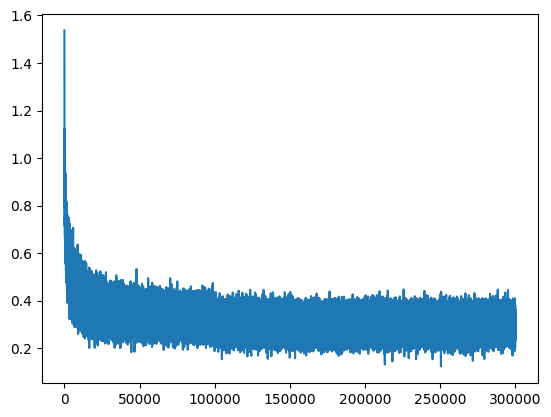

In [57]:
plt.plot(stepi, lossi)

In [58]:
# training loss 
print('original loss was 2.115 with 250000 iterations and 300 neurons in hidden layer and output layer')
print('then loss was 2.0942 but validation loss grew slightly, test loss aslo grew')
print('then loss was 2.0266 but validation loss grew slightly, test loss aslo grew')
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

original loss was 2.115 with 250000 iterations and 300 neurons in hidden layer and output layer
then loss was 2.0942 but validation loss grew slightly, test loss aslo grew
then loss was 2.0266 but validation loss grew slightly, test loss aslo grew


tensor(2.0124, grad_fn=<NllLossBackward0>)

In [59]:
# validation loss
print('previous devloss was 2.1527')
print('then devloss was 2.1527')
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

previous devloss was 2.1527
then devloss was 2.1527


tensor(2.1456, grad_fn=<NllLossBackward0>)

In [60]:
# test loss
print('previous test loss was 2.1510')
print('previous test loss was 2.1378')
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

previous test loss was 2.1510
previous test loss was 2.1378


tensor(2.1393, grad_fn=<NllLossBackward0>)

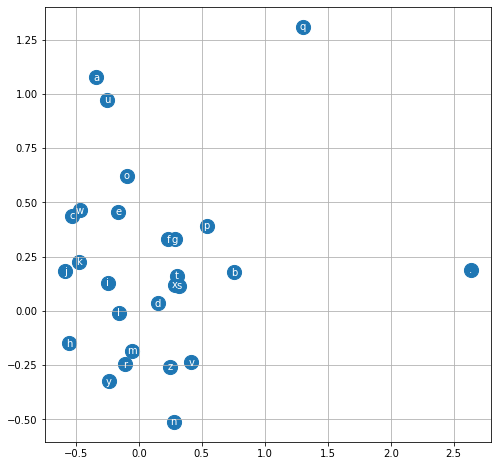

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [61]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nder.
alee.
than.
engrlfwandered.
elin.
shi.
jenne.
elisson.
arleptelle.
kalin.
shuhargahiman.
trick.
welle.
xabella.
ubakard.
ryylene.
ehs.
